# Aditya Birla Finance

In [1]:
# Load necessary libraries
import sys
import warnings
warnings.filterwarnings('ignore')
import datetime
import pandas as pd
import tqdm.notebook as tqdm
from tqdm.auto import tqdm
tqdm.pandas()

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

import utils.helper
from utils.helper import Processor
import importlib
importlib.reload(utils.helper)

import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 900
svg_renderer.height = 500
pio.renderers.default = "svg"
import plotly.express as px

In [2]:
# Load data
df = pd.read_csv('./../../data/nbfc/aditya_birla_finance/aditya_birla_finance.csv')

In [3]:
# Company username
company_username = 'abfinance'

In [4]:
# Correct the format of variables
df['inReplyToTweetId'] = df['inReplyToTweetId'].apply(lambda x: '%.0f' % x).values.tolist()
df['conversation_id'] = df['conversation_id'].astype(str)

In [5]:
# Declare the query words
query_words = ['dm', 'customer experience', 'inconvenience', 'concern team', 'resolve', 
                'solve', 'no noc', 'await response', 'unpleasant experience']

In [6]:
# Declare the processor object
processor = Processor('./../../data/config.json')

In [7]:
# Check whether an observation is query for the company or not
df['is_query'] = 0

for word in tqdm(query_words):
    df['is_query'] = df['is_query'] + df['tweet'].apply(processor.word_distribution, find=word).astype(int)

  0%|          | 0/9 [00:00<?, ?it/s]

In [13]:
df[df['conversation_id'] == '1341258852931551233']

,tweet,conversation_id,date,hashtags,id,inReplyToTweetId,reply_to,language,likes_count,media,...,favourites_count,user_status_count,location,name,description,verified,url,user_id,username,is_query
6,@abccare Another ticket raised with Aditya bir...,1341258852931551233,2020-12-22 05:46:44+00:00,NaN,1341258852931551233,nan,NaN,en,0,NaN,...,77,222,"Bengaluru, India",NITIN GOYAL,Software Developer,False,NaN,140704864,NITINGOYAL88,0


In [14]:
df[df['username'] == company_username]

,tweet,conversation_id,date,hashtags,id,inReplyToTweetId,reply_to,language,likes_count,media,...,favourites_count,user_status_count,location,name,description,verified,url,user_id,username,is_query
138,"@ShrinuJuttu @KumarMBirla Hi Shrinu, Thank you...",1318081260539949056,2020-10-19 10:12:52+00:00,NaN,1318133004565319687,1318081260539949056,https://twitter.com/ShrinuJuttu,en,0,NaN,...,62,2267,NaN,ABC - Aditya Birla Finance,Financing products from Aditya Birla Capital e...,False,http://abfl.adityabirlacapital.com,847421215627030528,abfinance,0
737,@lawmanrohan1 Hi. We understand your situation...,1246747025678327808,2020-04-05 12:02:36+00:00,NaN,1246770208649269249,1246768826655670272,https://twitter.com/lawmanrohan1,en,0,NaN,...,62,2267,NaN,ABC - Aditya Birla Finance,Financing products from Aditya Birla Capital e...,False,http://abfl.adityabirlacapital.com,847421215627030528,abfinance,0
738,"@lawmanrohan1 Hi, You have reached Aditya Birl...",1246747025678327808,2020-04-05 11:48:19+00:00,NaN,1246766614361468929,1246765487939149824,https://twitter.com/lawmanrohan1,en,0,NaN,...,62,2267,NaN,ABC - Aditya Birla Finance,Financing products from Aditya Birla Capital e...,False,http://abfl.adityabirlacapital.com,847421215627030528,abfinance,0


In [8]:
# Select observations of queries
qdf = df[(df['is_query']>0) & (df['username'] == company_username)]

In [9]:
qdf.shape

(0, 28)

In [10]:
# Get all the conversation ids
conversation_ids = qdf['conversation_id'].unique()
print(f"Total number of unique conversations: {len(conversation_ids)}")

Total number of unique conversations: 0


In [11]:
df['date'] = pd.to_datetime(df['date'])

## Response time

Response time is the time the company takes to respond to the first query.

In [12]:
result = pd.DataFrame()
result['conversation_id'] = conversation_ids
result['response_time'] = 0

In [13]:
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    response_time = (comp_tmp.iloc[0]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
    result.at[index, 'response_time'] = response_time

In [14]:
result

,conversation_id,response_time


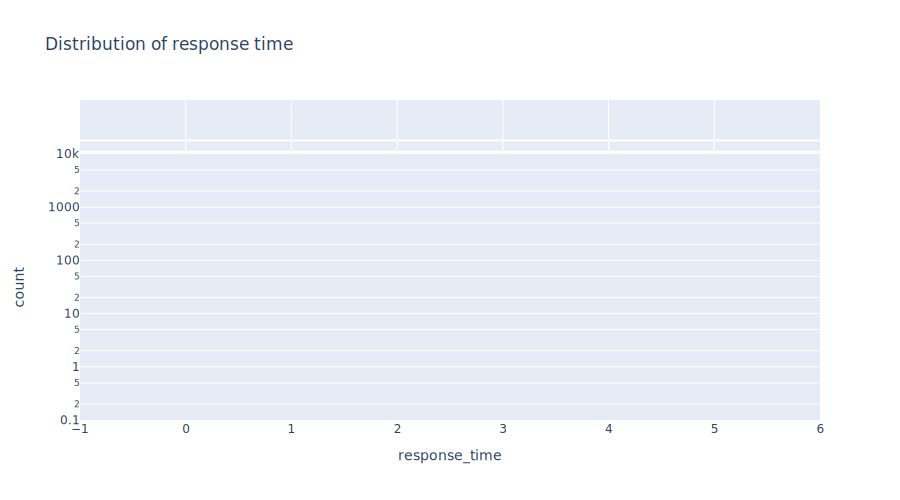

In [15]:
fig = px.histogram(result[result['response_time']<1000], x='response_time', log_y=True, marginal='box', title='Distribution of response time')
fig.show()

## Resolution time

Assuming that if the last query in the conversation is from the company then the issue is resolved.  
Resolution time is the time difference between the last date of last tweet in the conversation and the date of first query.

In [107]:
result['resolution_time'] = 0

In [108]:
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[-1]['username'] == company_username:
        resolution_time = (tmp.iloc[-1]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
        result.at[index, 'resolution_time'] = resolution_time

In [116]:
print(f"Number of queries resolved: {len(result['resolution_time'].to_numpy().nonzero()[0])}")
print(f"Number of queries unresolved: {result.shape[0] - len(result['resolution_time'].to_numpy().nonzero()[0])}")

Number of queries resolved: 547
Number of queries unresolved: 189


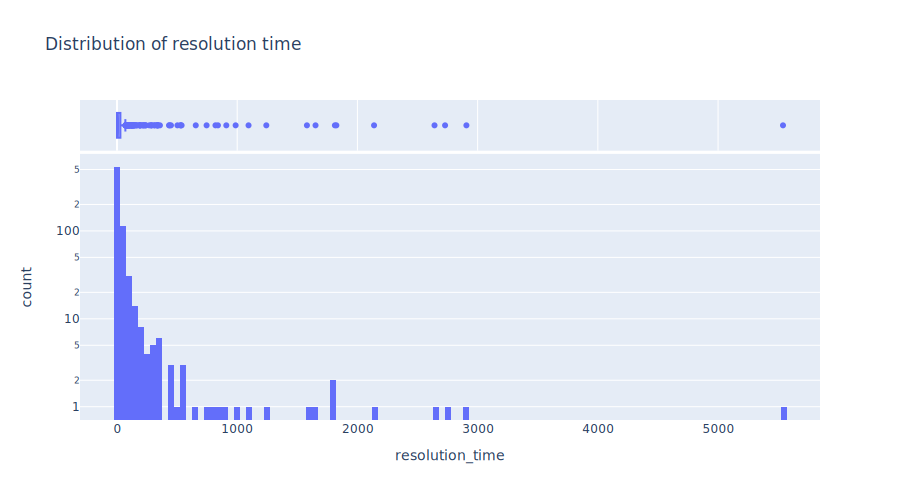

In [109]:
fig = px.histogram(result, x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()